In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
import scipy
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
from math import pi, sqrt
import pywt
import os
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from joblib import dump, load

In [17]:
imagecsv = pd.read_csv(r'/content/drive/MyDrive/Diabetic Retinopathy Detection/trainLabels.csv')[:3000]
img_pt = r'/content/drive/MyDrive/Diabetic Retinopathy Detection/sample_images_resized'
imagecsv.head

<bound method NDFrame.head of            image  level
0        10_left      0
1       10_right      0
2        13_left      0
3       13_right      0
4        15_left      1
...          ...    ...
2995  3706_right      0
2996   3708_left      0
2997  3708_right      0
2998   3710_left      0
2999  3710_right      0

[3000 rows x 2 columns]>

Text(0, 0.5, 'Images')

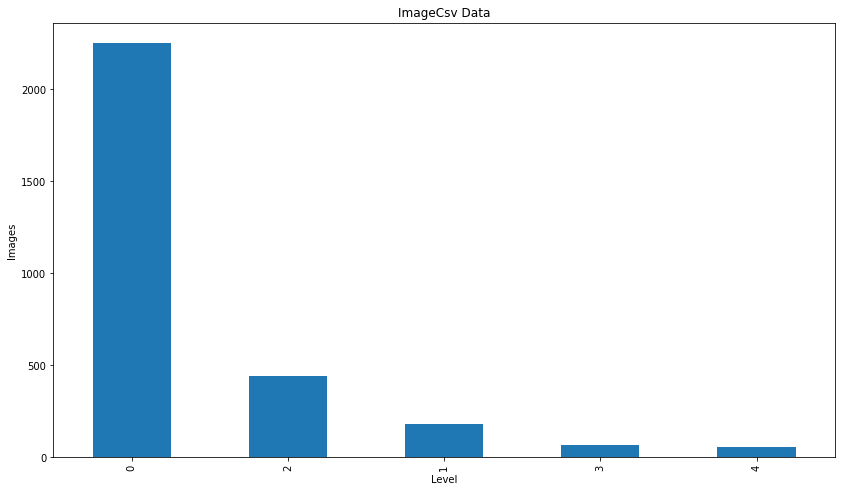

In [18]:
ax = imagecsv['level'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="ImageCsv Data")
ax.set_xlabel("Level")
ax.set_ylabel("Images")

In [ ]:
def discrete_wave_transform(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA

def gaussian_matched_filter_kernel(L, sigma, t = 3, mf = True):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]
    filters = []
    ksize = 31
    
    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)

    return kernels,filters

#Given a filter bank, apply them and record maximum response
def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

def kmeans(image):
    img = image.reshape((576, 750))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return np.array(res2).flatten()

immatrix=[]

for index, row in imagecsv.iterrows():
  
  img_path = os.path.join(img_pt,row['image']+'.png')

  if not os.path.isfile(img_path):
    continue
  img = cv2.imread(img_path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  equ = cv2.equalizeHist(img_gray)

  dwt_img = discrete_wave_transform(equ)

  kernel = gaussian_matched_filter_kernel(20, 5)
  kernels,filters = createMatchedFilterBank(kernel, 4)

  equ3 = applyFilters(dwt_img,kernels)
  equ4 = applyFilters(equ3,filters)
  kmeans_img = kmeans(equ4)
  immatrix.append(kmeans_img)

imagecsv['data'] = immatrix

In [20]:
#imagecsv.to_pickle(r'/content/drive/MyDrive/Diabetic Retinopathy Detection/diabetic_retinopathy_df.pkl')
imagecsv = pd.read_pickle(r'/content/drive/MyDrive/Diabetic Retinopathy Detection/diabetic_retinopathy_df.pkl')
imagecsv.head

<bound method NDFrame.head of            image  level                                               data
0        10_left      0  [211, 203, 212, 211, 203, 212, 211, 203, 212, ...
1       10_right      0  [47, 41, 47, 47, 41, 47, 47, 41, 47, 47, 41, 4...
2        13_left      0  [10, 0, 10, 10, 0, 10, 10, 0, 10, 10, 0, 10, 1...
3       13_right      0  [212, 201, 212, 212, 201, 212, 212, 201, 212, ...
4        15_left      1  [56, 50, 56, 56, 50, 56, 56, 50, 56, 56, 50, 5...
...          ...    ...                                                ...
2995  3706_right      0  [96, 82, 98, 96, 82, 98, 96, 82, 98, 96, 82, 9...
2996   3708_left      0  [143, 132, 142, 143, 132, 142, 143, 132, 142, ...
2997  3708_right      0  [214, 202, 214, 214, 202, 214, 214, 202, 214, ...
2998   3710_left      0  [96, 88, 97, 96, 88, 97, 96, 88, 97, 96, 88, 9...
2999  3710_right      0  [175, 162, 175, 175, 162, 175, 175, 162, 175, ...

[3000 rows x 3 columns]>

197_right
0


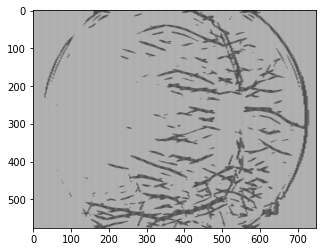

In [23]:
i = 167
print(imagecsv['image'][i])
print(imagecsv['level'][i])
plt.imshow(imagecsv['data'][i].reshape((576, 750)),cmap='gray')
plt.show()

# Model training

In [25]:
clf = SVC()

In [24]:
X = np.row_stack(imagecsv['data'])
y = np.array(imagecsv['level'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

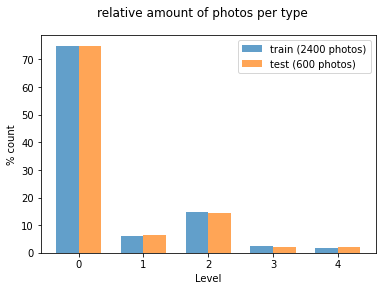

In [26]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Level')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

In [ ]:
#clf.fit(X_train, y_train)

#dump(clf, r'/content/drive/MyDrive/Diabetic Retinopathy Detection/diabetic_retinopathy_trained_model.joblib')
clf = load(r'/content/drive/MyDrive/Diabetic Retinopathy Detection/diabetic_retinopathy_trained_model.joblib')

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7483333333333333


In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       449
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        87
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        13

    accuracy                           0.75       600
   macro avg       0.15      0.20      0.17       600
weighted avg       0.56      0.75      0.64       600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
